In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/aiproject")

In [ ]:
import scripts.dl.data_setup as data_setup
import os
from pathlib import Path

image_path = Path(os.path.join(os.getcwd(), 'data', 'tomo_0.5_0.25_0.25'))
train_dataloader, test_dataloader, val_dataloader, class_names = data_setup.create_dataloaders(
    os.path.join(image_path, 'train'),
    os.path.join(image_path, 'test'),
    os.path.join(image_path, 'val'),
    train_transform=data_setup.TRAIN_TRANSFORM,
    test_transform=data_setup.TEST_TRANSFORM,
    batch_size=32,
    num_workers=data_setup.NUM_WORKERS)

In [ ]:
# data_setup.plot_transformed_images(list(image_path.glob("*/*/*.jpeg")),
#                         transform=data_setup.TRAIN_TRANSFORM,
#                         n=3)

In [ ]:
import torch
import scripts.dl.model_builder as model_builder, scripts.dl.utils as utils

# Setup hyperparameters
NUM_EPOCHS = 300
BATCH_SIZE = 32
HIDDEN_UNITS = 100
LEARNING_RATE = 0.01

# Create model with help from model_builder.py
model = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=HIDDEN_UNITS
).to(model_builder.DEVICE)

# Set loss and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(),
                             lr=LEARNING_RATE)

# Start training with help from engine.py
results = model_builder.train(model=model,
                              train_dataloader=train_dataloader,
                              test_dataloader=val_dataloader,
                              loss_fn=loss_fn,
                              optimizer=optimizer,
                              epochs=NUM_EPOCHS,
                              device=model_builder.DEVICE)

# Save the model with help from utils.py
utils.save_model(model=model,
                 target_dir="models",
                 model_name="tiny_vgg.pth")

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6937 | train_acc: 0.5000 | test_loss: 0.6940 | test_acc: 0.4892
Epoch: 2 | train_loss: 0.6934 | train_acc: 0.4999 | test_loss: 0.6937 | test_acc: 0.4892
Epoch: 3 | train_loss: 0.6933 | train_acc: 0.5001 | test_loss: 0.6936 | test_acc: 0.4892
Epoch: 4 | train_loss: 0.6933 | train_acc: 0.5001 | test_loss: 0.6934 | test_acc: 0.4892
Epoch: 5 | train_loss: 0.6933 | train_acc: 0.5005 | test_loss: 0.6934 | test_acc: 0.4892
Epoch: 6 | train_loss: 0.6932 | train_acc: 0.4989 | test_loss: 0.6933 | test_acc: 0.4892
Epoch: 7 | train_loss: 0.6932 | train_acc: 0.4973 | test_loss: 0.6932 | test_acc: 0.4892
Epoch: 8 | train_loss: 0.6932 | train_acc: 0.4928 | test_loss: 0.6932 | test_acc: 0.4892
Epoch: 9 | train_loss: 0.6931 | train_acc: 0.4956 | test_loss: 0.6931 | test_acc: 0.4928
Epoch: 10 | train_loss: 0.6930 | train_acc: 0.5162 | test_loss: 0.6931 | test_acc: 0.5335
Epoch: 11 | train_loss: 0.6931 | train_acc: 0.5109 | test_loss: 0.6931 | test_acc: 0.5189
Epoch: 12 | train_l

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

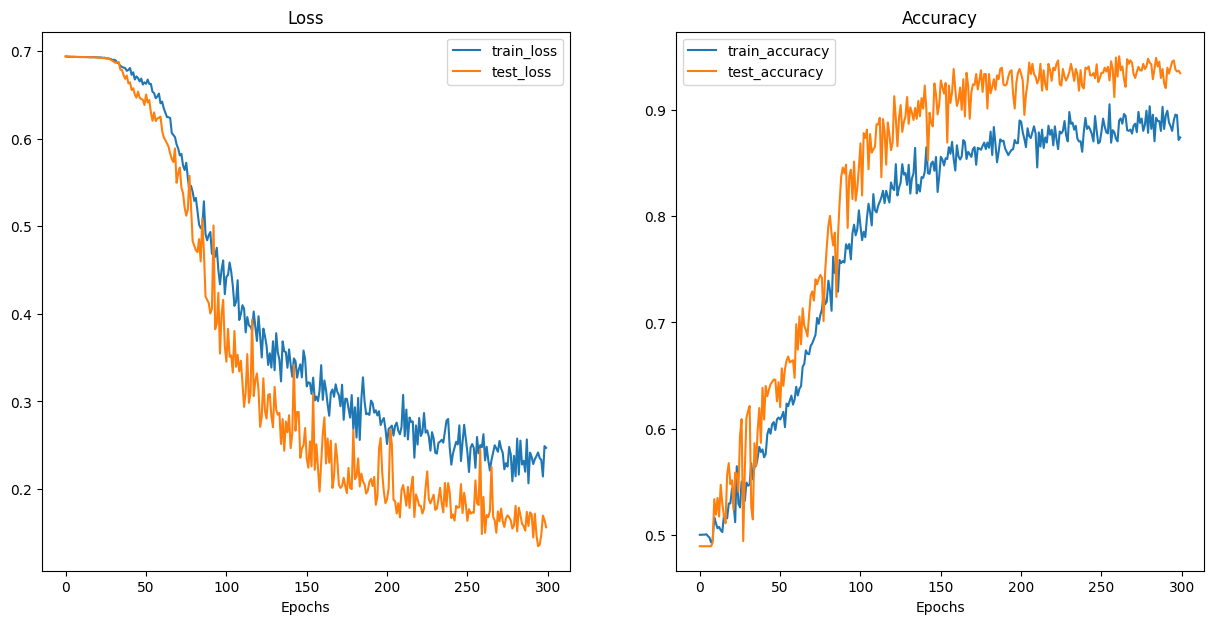

In [ ]:
plot_loss_curves(results)

In [ ]:
# Define a function to calculate accuracy
def calculate_accuracy(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)

            # Forward pass
            outputs = model(data)

            # Apply sigmoid and round predictions to get binary output
            predicted = torch.round(torch.sigmoid(outputs))

            # Make sure targets are also reshaped to match the predicted tensor
            targets = targets.view_as(predicted)

            # Count correct predictions
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    accuracy = correct / total if total > 0 else 0
    return accuracy

# Calculate and print test accuracy
test_accuracy = calculate_accuracy(model=model, dataloader=test_dataloader, device=model_builder.DEVICE)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 93.86%
